# A Simulation Framework for Magnetic Continuum Robots
### Roland Dreyfus, Quentin Boehler, Bradley J. Nelson
---
# Data visualization

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import ipympl
from IPython.display import display

%matplotlib inline

# 1. Load data from experiment and simulation
Load one of the datasets before continuing with cell ***2. Parse, resample and crop data***

Datasets:
* Vessel environment
* Obstacle free environment for calibration
* Free-form environment

### Vessel environment

In [65]:
# params 9976 vessels
csv_sim = '../data/01_tip_pose/21_rod_sim_tip_topic_9976/tip_pose_9976_2022-02-15-17-31-18.csv'
csv_exp = '../data/01_tip_pose/11_video_tracker_9976/20220218_MVI_9976_trim.csv'
offset_xy = [-0.001, 0.004] # m

# crop into sections (sec)
video_sequence = [271, 320]
video_sect_1 = [271, 287]
video_sect_2 = [299.9, 320]

time_waypoints = [289.0, 304.1, 311.2, 322.7]  # s

# load data
df_sim = pd.read_csv(csv_sim)
df_exp = pd.read_csv(csv_exp)

### Obstacle free environment for calibration

In [61]:
# params 9978 calibration
csv_sim = '../data/01_tip_pose/22_rod_sim_tip_topic_9978/tip_pose_9978_2022-02-17-18-22-51.csv'
csv_exp = '../data/01_tip_pose/12_video_tracker_9978/20220217_MVI_9978_trim.csv'
offset_xy = [-0.001, -0.001] # m

# crop into sections (sec)
video_sequence = [100, 121]
video_sect_1 = [100, 121]
video_sect_2 = [100, 121]

time_waypoints = [108.8, 115.9, 123.8]  # s

# load data
df_sim = pd.read_csv(csv_sim)
df_exp = pd.read_csv(csv_exp)

### Free-form environment

In [62]:
# params 9975 circles
csv_sim = '../data/01_tip_pose/23_rod_sim_tip_topic_9975/tip_pose_9975_2022-02-18-09-38-29.csv'
csv_exp = '../data/01_tip_pose/13_video_tracker_9975/20220218_MVI_9975_trim.csv'
offset_xy = [0.002, 0.003] # m

# crop into sections (sec)
video_sequence = [200, 249]  # sec
video_sect_1 = [200., 225]
video_sect_2 = [230., 246]

time_waypoints = [213.1, 227.8, 235.9, 249.2]  # s

# load data
df_sim = pd.read_csv(csv_sim)
df_exp = pd.read_csv(csv_exp)

In [63]:
display(df_sim)
display(df_exp)

# 2. Parse, resample and crop data

,%time,field.position.x,field.position.y,field.position.z,field.orientation.x,field.orientation.y,field.orientation.z,field.orientation.w
0,1645173509453205846,-0.005048,-0.076300,0.000000e+00,0.499829,0.500171,0.500266,0.499734
1,1645173509511002963,-0.005048,-0.076300,0.000000e+00,0.499829,0.500171,0.500266,0.499734
2,1645173509571624464,-0.005048,-0.076300,0.000000e+00,0.499829,0.500171,0.500266,0.499734
3,1645173509625706784,-0.005048,-0.076300,0.000000e+00,0.499829,0.500171,0.500266,0.499734
4,1645173509678213484,-0.005048,-0.076300,0.000000e+00,0.499829,0.500171,0.500266,0.499734
...,...,...,...,...,...,...,...,...
813,1645173568843859269,0.007012,0.033452,3.824910e-08,0.694853,0.101595,0.103259,0.704412
814,1645173568954615218,0.006530,0.033519,3.824910e-08,0.694104,0.107266,0.109017,0.703441
815,1645173569046808856,0.006043,0.033576,3.824910e-08,0.693239,0.113270,0.115103,0.702383
816,1645173569127782343,0.005437,0.033456,3.824910e-08,0.692885,0.115910,0.117773,0.701858


,t,x,y,ang
0,1.48,-0.005912,-0.066463,-0.017240
1,1.52,-0.005505,-0.065647,-0.048349
2,1.56,-0.005505,-0.065036,0.000000
3,1.60,-0.005505,-0.064628,0.015872
4,1.64,-0.005505,-0.064016,-0.015624
...,...,...,...,...
8345,454.12,-0.003262,-0.062793,0.126308
8346,454.16,-0.003874,-0.063405,0.112427
8347,454.20,-0.004281,-0.064016,0.079199
8348,454.24,-0.004281,-0.065036,0.096474


In [66]:
# simulation time (nsec machine clock) to video time (sec)
t_sim_shift = 3

df_sim['%time'] = df_sim['%time']*1e-9
delta_t = video_sequence[0] - df_sim['%time'][0]
df_sim['%time'] = df_sim['%time'] + delta_t

# crop data
# crop ends
df_sim = df_sim[df_sim['%time'].between(video_sequence[0]+t_sim_shift, video_sequence[1]+t_sim_shift)]
df_exp = df_exp[df_exp['t'].between(video_sequence[0], video_sequence[1])]

# resample data
sampling_rate =300  # in ms

df_sim['date'] = pd.to_datetime(df_sim['%time'], unit='s')
df_sim['date'].iloc[0] =  pd.to_datetime(video_sequence[0]+t_sim_shift, unit='s')
df_sim['date'].iloc[-1] =  pd.to_datetime(video_sequence[1]+t_sim_shift, unit='s')
df_sim = df_sim.set_index('date').resample(str(sampling_rate)+'ms').mean().interpolate()

df_exp['date'] = pd.to_datetime(df_exp['t'], unit='s')
df_exp['date'].iloc[0] =  pd.to_datetime(video_sequence[0], unit='s')
df_exp['date'].iloc[-1] =  pd.to_datetime(video_sequence[1], unit='s')
df_exp = df_exp.set_index('date').resample(str(sampling_rate)+'ms').mean().interpolate()

# parse data from simulation
# time
time_sim = df_sim['%time'].to_numpy()
# position
tip_pos_sim = np.empty([3,len(df_sim)])
tip_quat_sim = np.empty([4,len(df_sim)])
tip_pos_sim[0] = df_sim['field.position.x'].to_numpy()
tip_pos_sim[1] = df_sim['field.position.y'].to_numpy()

# qutat
tip_quat_sim[0] = df_sim['field.orientation.x'].to_numpy()
tip_quat_sim[1] = df_sim['field.orientation.y'].to_numpy()
tip_quat_sim[2] = df_sim['field.orientation.z'].to_numpy()
tip_quat_sim[3] = df_sim['field.orientation.w'].to_numpy()
# direction and angle
direction = np.empty((3, np.shape(tip_quat_sim[1])[0]))
tip_angle_sim = np.empty((np.shape(tip_quat_sim[1])[0], 1))  # (rad)
for i in range(np.shape(tip_quat_sim[1])[0]):
    r = R.from_quat([tip_quat_sim[:,i]])
    rot_mx = r.as_matrix()[0]
    direction[:,i] = rot_mx[:,0]
    tip_angle_sim[i] = np.arctan2(direction[0,i], direction[1,i])
    
# parse data from experiment
tip_pos_exp = np.empty([3,len(df_exp)])

time_exp = df_exp['t'].to_numpy()
tip_pos_exp[0] = df_exp['x'].to_numpy()+offset_xy[0]
tip_pos_exp[1] = df_exp['y'].to_numpy()+offset_xy[1]
tip_angle_exp = df_exp['ang'].to_numpy() # rad
direct_exp = [np.sin(tip_angle_exp), np.cos(tip_angle_exp)]

# position error between simulation and experiment
pos_error = np.sqrt((tip_pos_sim[0]-tip_pos_exp[0])**2 + (tip_pos_sim[1]-tip_pos_exp[1])**2)
# angle error between simulation and experiment
ang_error = np.rad2deg(tip_angle_sim.T[0]-tip_angle_exp)
ang_error = np.sqrt(ang_error**2)

/tmp/ipykernel_555064/2443117065.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sim['date'].iloc[0] =  pd.to_datetime(video_sequence[0]+t_sim_shift, unit='s')
/tmp/ipykernel_555064/2443117065.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sim['date'].iloc[-1] =  pd.to_datetime(video_sequence[1]+t_sim_shift, unit='s')
/tmp/ipykernel_555064/2443117065.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp['date'].i

# 3. Plot position and orientation path and way-points

way-point idx: 50
time: 289.0 s
time since start: 14.9 s
position error: 0.6 mm
angle error: 3.1 °
---
way-point idx: 100
time: 304.1 s
time since start: 30.0 s
position error: 4.9 mm
angle error: 1.9 °
---
way-point idx: 124
time: 311.2 s
time since start: 37.1 s
position error: 1.1 mm
angle error: 1.3 °
---
way-point idx: 162
time: 322.7 s
time since start: 48.6 s
position error: 5.0 mm
angle error: 3.0 °
---

position error avg:  4.8  mm
angle error avg:  3.8  deg


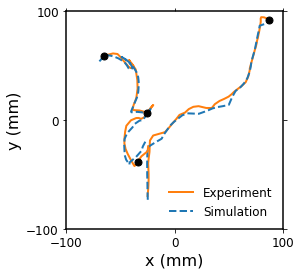

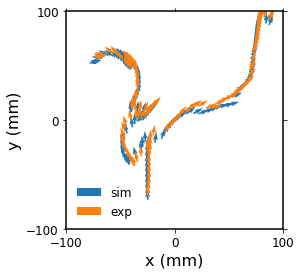

In [67]:
# plot
fig, axs = plt.subplots(1, 1)
line_width = 2

# index section 1
idx_sim_1 = np.argwhere((time_sim > video_sect_1[0]+t_sim_shift) & (time_sim < video_sect_1[1]+t_sim_shift))
idx_exp_1 = np.argwhere((time_exp > video_sect_1[0]) & (time_exp < video_sect_1[1]))
# index section 2
idx_sim_2 = np.argwhere((time_sim > video_sect_2[0]+t_sim_shift) & (time_sim < video_sect_2[1]+t_sim_shift))
idx_exp_2 = np.argwhere((time_exp > video_sect_2[0]) & (time_exp < video_sect_2[1]))

# plot section 1
axs.plot(
    tip_pos_exp[0][idx_exp_1]*1e3, tip_pos_exp[1][idx_exp_1]*1e3,
    '-', linewidth=line_width, label="Experiment", color='tab:orange')
axs.plot(
    tip_pos_sim[0][idx_sim_1]*1e3, tip_pos_sim[1][idx_sim_1]*1e3,
    '--', linewidth=line_width, label="Simulation", color='tab:blue')

# plot section 2
axs.plot(
    tip_pos_exp[0][idx_exp_2]*1e3, tip_pos_exp[1][idx_exp_2]*1e3,
    '-', linewidth=line_width, color='tab:orange')
axs.plot(
    tip_pos_sim[0][idx_sim_2]*1e3, tip_pos_sim[1][idx_sim_2]*1e3,
    '--', linewidth=line_width, color='tab:blue')

# plot way-point
for t in time_waypoints:
    i = find_nearest_idx(time_sim, t)
    time_duration = t-time_sim[0]
    axs.plot(
    tip_pos_exp[0][i]*1e3, tip_pos_exp[1][i]*1e3,
    'o', color='k', markersize=7) # , markerfacecolor='None', markeredgewidth=2)
    print('way-point idx:', i)
    print('time:', np.round(time_sim[i], 1), 's')
    print('time since start:', np.round(time_duration, 1), 's')
    print('position error:', np.round(pos_error[i]*1e3, 1), 'mm')
    print('angle error:', np.round(ang_error[i], 1), '°')
    print('---')

print()
print('position error avg: ', np.round(np.mean(pos_error)*1e3, 1), ' mm')
print('angle error avg: ', np.round(np.mean(ang_error), 1), ' deg')

axs.set_aspect('equal', 'box')
axs.set_xlabel('x (mm)', fontsize=16)
axs.set_ylabel('y (mm)', fontsize=16)
handles, labels = axs.get_legend_handles_labels()
axs.legend(loc='lower right', fontsize=12, frameon=False)
axs.tick_params(axis='both', which='major', labelsize=12)
axs.set_xlim([-0.1*1e3, 0.1*1e3])
axs.set_ylim([-0.1*1e3, 0.1*1e3])
axs.locator_params(nbins=3)
axs.tick_params(right=True, top=True)
for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(1.5)
    
# angle plot
fig_2, axs_0 = plt.subplots(1, 1)
# section 1
axs_0.quiver(
    tip_pos_sim[0][idx_sim_1]*1e3, tip_pos_sim[1][idx_sim_1]*1e3,
    direction[0][idx_sim_1], direction[1][idx_sim_1], label="sim", scale = 20, color='tab:blue')
axs_0.quiver(
    tip_pos_exp[0][idx_exp_1]*1e3, tip_pos_exp[1][idx_exp_1]*1e3,
    direct_exp[0][idx_exp_1], direct_exp[1][idx_exp_1], label="exp", scale = 20, color='tab:orange')
# section 1
axs_0.quiver(
    tip_pos_sim[0][idx_sim_2]*1e3, tip_pos_sim[1][idx_exp_2]*1e3,
    direction[0][idx_sim_2], direction[1][idx_sim_2], scale = 20, color='tab:blue')
axs_0.quiver(
    tip_pos_exp[0][idx_exp_2]*1e3, tip_pos_exp[1][idx_exp_2]*1e3,
    direct_exp[0][idx_exp_2], direct_exp[1][idx_exp_2], scale = 20, color='tab:orange')

axs_0.set_aspect('equal', 'box')
axs_0.set_xlabel('x (mm)', fontsize=16)
axs_0.set_ylabel('y (mm)', fontsize=16)
handles, labels = axs_0.get_legend_handles_labels()
axs_0.legend(loc='lower left', fontsize=12, frameon=False)
axs_0.tick_params(axis='both', which='major', labelsize=12)
axs_0.set_xlim([-0.1*1e3, 0.1*1e3])
axs_0.set_ylim([-0.1*1e3, 0.1*1e3])
axs_0.locator_params(nbins=3)
axs_0.tick_params(right=True, top=True)
for axis in ['top','bottom','left','right']:
    axs_0.spines[axis].set_linewidth(1.5)

# 4.Plot error

position error at time 289 s:  0.6 mm
position error at time 304 s:  4.9 mm
position error at time 311 s:  1.1 mm
position error at time 322 s:  5.0 mm
---
postition error mean:          4.8 mm
angle error mean:              3.8 mm


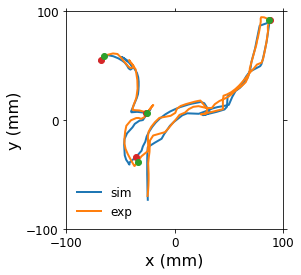

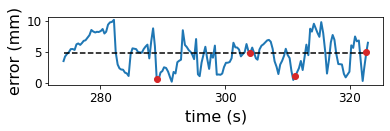

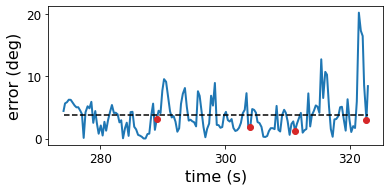

In [68]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# plot resampled data
fig_1, axs_1 = plt.subplots(1, 1)
fig_2, axs_2 = plt.subplots(1, 1)
fig_3, axs_3 = plt.subplots(1, 1)
#plt.rcParams['figure.figsize'] = [10, 30]

axs_1.plot(tip_pos_sim[0]*1e3, tip_pos_sim[1]*1e3, '-', linewidth=2, label="sim")
axs_1.plot(tip_pos_exp[0]*1e3, tip_pos_exp[1]*1e3, '-', linewidth=2, label="exp")

# plot error position and angle
axs_2.plot(time_sim, pos_error*1e3, '-', linewidth=2)
axs_3.plot(time_sim, ang_error, '-', linewidth=2)

axs_1.set_aspect('equal', 'box')
axs_2.set_aspect(1, 'box')
axs_3.set_aspect(1, 'box')

# mean of pos and angle
pos_error_mean = np.ones((len(time_sim),1))*np.mean(pos_error)
axs_2.plot(time_sim, pos_error_mean*1e3, '--', color='k')

ang_error_mean = np.ones((len(time_sim),1))*np.mean(ang_error)
axs_3.plot(time_sim, ang_error_mean, '--', color='k')

for t in time_waypoints:

    i = find_nearest_idx(time_sim, t)
    print('position error at time', int(t), 's: ', np.round(pos_error[i]*1e3, 1), 'mm')
    
    axs_1.plot(tip_pos_sim[0][i]*1e3, tip_pos_sim[1][i]*1e3, 'o', linewidth=2, color='tab:red')
    axs_1.plot(tip_pos_exp[0][i]*1e3, tip_pos_exp[1][i]*1e3, 'o', linewidth=2, color='tab:green')

    # plot error position
    axs_2.plot(time_sim[i], pos_error[i]*1e3, 'o', linewidth=2, label="sim", color='tab:red')
    # plot error angle
    axs_3.plot(time_sim[i], ang_error[i], 'o', linewidth=2, label="sim", color='tab:red')
    
axs_1.set_xlabel('x (mm)', fontsize=16)
axs_1.set_ylabel('y (mm)', fontsize=16)
handles, labels = axs_1.get_legend_handles_labels()
axs_1.legend(loc='lower left', fontsize=12, frameon=False)
axs_1.tick_params(axis='both', which='major', labelsize=12)
axs_1.set_xlim([-100, 100])
axs_1.set_ylim([-100, 100])
axs_1.locator_params(nbins=3)
axs_1.tick_params(right=True, top=True)

axs_2.set_xlabel('time (s)', fontsize=16)
axs_2.set_ylabel('error (mm)', fontsize=16)
handles, labels = axs_2.get_legend_handles_labels()
axs_2.tick_params(axis='both', which='major', labelsize=12)
axs_2.locator_params(nbins=3)

axs_3.set_xlabel('time (s)', fontsize=16)
axs_3.set_ylabel('error (deg)', fontsize=16)
handles, labels = axs_3.get_legend_handles_labels()
axs_3.tick_params(axis='both', which='major', labelsize=12)
axs_3.locator_params(nbins=3)

print('---')
print('postition error mean:         ', np.round(np.mean(pos_error)*1000, 1), 'mm')
print('angle error mean:             ', np.round(np.mean(ang_error), 1), 'mm')

# Export figure
Only one figure is exported. Change figure variable and file name to export the chosen figure.

In [ ]:
# export figure

# make text editable in inkskape
mpl.use('svg')
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

# export
fig_2.savefig("exp_sim_plot.svg", transparent=True)